# Проект e-commerce

Требуется проанализировать совершенные покупки и найти ответы на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 

5.1. Выполнить когортный анализ пользователей.

5.2. В период с января по декабрь выявить когорту с самым высоким retention на 3-й месяц. 

6. Построить RFM-сегментацию пользователей, чтобы качественно оценить аудиторию. В кластеризации выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время.

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta

# Предобработка и знакомство с данными

### Загрузим данные через pandas и проведем первичный осмотр

### 1) таблица с уникальными идентификаторами пользователей

In [2]:
customers = pd.read_csv('../first_project/data/olist_customers_dataset.csv')

In [3]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


### 2) таблица заказов

In [5]:
orders = pd.read_csv('../first_project/data/olist_orders_dataset.csv')

In [6]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


### 3) товарные позиции, входящие в заказы

In [8]:
items = pd.read_csv('../first_project/data/olist_order_items_dataset.csv')

In [9]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [10]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


## Визуализируем структуру нашей базы данных. В качестве инструмента используем drawSQL.

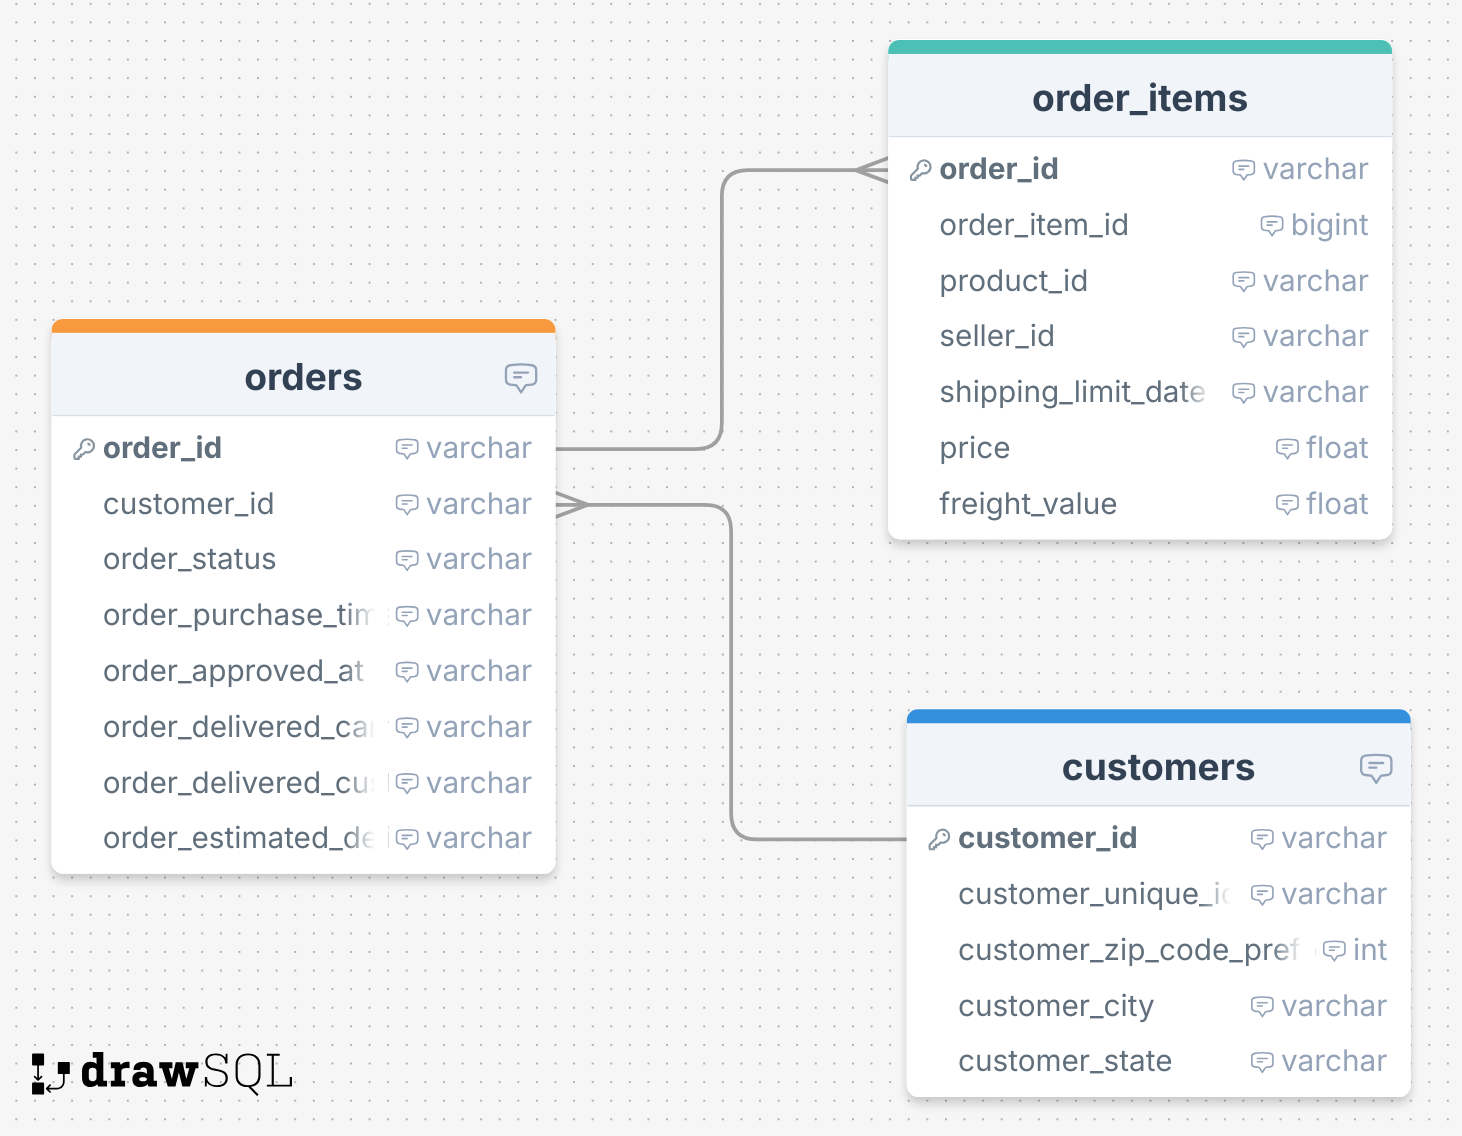

### Бросаются в глаза длинные названия некоторых полей, а также поля с датой и временем имеют строковый тип данных (что будет неудобно при будущих расчетах). Исправим это:

In [11]:
# сократим названия некоторых колонок для удобства

customers.rename(columns={'customer_zip_code_prefix': 'zip_code_prefix',
                         'customer_city': 'city',
                         'customer_state': 'state'
                         }, inplace=True)

orders.rename(columns={'order_purchase_timestamp': 'purchase_timestamp',
                       'order_approved_at': 'approved_at',
                       'order_delivered_carrier_date': 'delivered_carrier_date',
                       'order_delivered_customer_date': 'delivered_customer_date',
                       'order_estimated_delivery_date': 'estimated_delivery_date'
                      }, inplace=True)

In [12]:
# переведем поля с датами и временем в нужный тип

orders = orders.astype({'purchase_timestamp': 'datetime64[ns]',
                       'approved_at': 'datetime64[ns]',
                       'delivered_carrier_date': 'datetime64[ns]',
                       'delivered_customer_date': 'datetime64[ns]',
                       'estimated_delivery_date': 'datetime64[ns]'})

items.shipping_limit_date = items.shipping_limit_date.astype('datetime64[ns]')

In [13]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         99441 non-null  object
 1   customer_unique_id  99441 non-null  object
 2   zip_code_prefix     99441 non-null  int64 
 3   city                99441 non-null  object
 4   state               99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_id                 99441 non-null  object        
 1   customer_id              99441 non-null  object        
 2   order_status             99441 non-null  object        
 3   purchase_timestamp       99441 non-null  datetime64[ns]
 4   approved_at              99281 non-null  datetime64[ns]
 5   delivered_carrier_date   97658 non-null  datetime64[ns]
 6   delivered_customer_date  96476 non-null  datetime64[ns]
 7   estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [15]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  int64         
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


## Так выглядит наша структура базы данных после изменений:

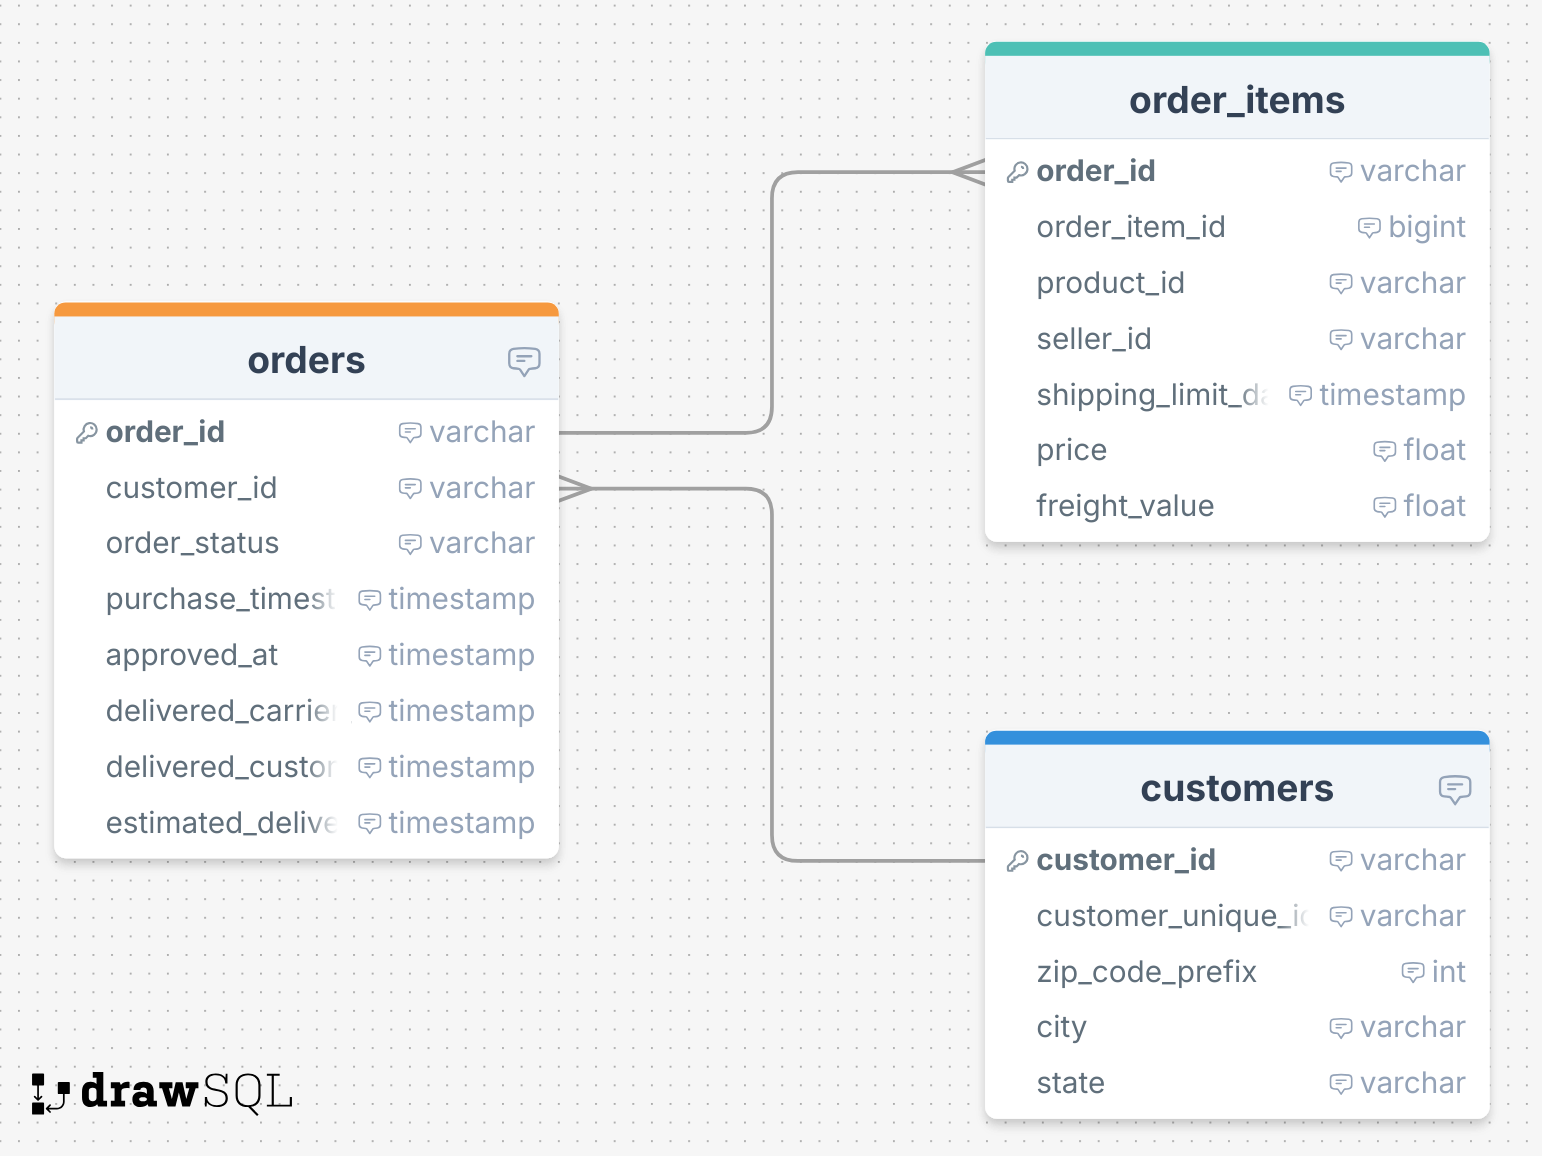

посмотрим данные на указанном в задании примере

In [16]:
orders[orders['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,customer_id,order_status,purchase_timestamp,approved_at,delivered_carrier_date,delivered_customer_date,estimated_delivery_date
36265,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06


In [17]:
customers[customers['customer_id'] == orders[orders['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']['customer_id'].to_string(index=False).strip()]

,customer_id,customer_unique_id,zip_code_prefix,city,state
58260,2e45292979b9b2700ea09560eeb0f803,bb8a37225e0279ac8a274c9765617eaf,74663,goiania,GO


In [18]:
items[items['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


### Заинтересовало поле customer_unique_id в таблице customers. 

In [19]:
customers.groupby('customer_unique_id', as_index=False).agg({'customer_id':'count'}).query('customer_id > 1')

,customer_unique_id,customer_id
33,00172711b30d52eea8b313a7f2cced02,2
106,004288347e5e88a27ded2bb23747066c,2
124,004b45ec5c64187465168251cd1c9c2f,2
144,0058f300f57d7b93c477a131a59b36c3,2
249,00a39521eb40f7012db50455bf083460,2
...,...,...
95784,ff36be26206fffe1eb37afd54c70e18b,3
95810,ff44401d0d8f5b9c54a47374eb48c1b8,2
95916,ff8892f7c26aa0446da53d01b18df463,2
95934,ff922bdd6bafcdf99cb90d7f39cea5b3,3


In [20]:
customers.query("customer_unique_id == 'ff36be26206fffe1eb37afd54c70e18b'").merge(orders, how='inner', on='customer_id')

,customer_id,customer_unique_id,zip_code_prefix,city,state,order_id,order_status,purchase_timestamp,approved_at,delivered_carrier_date,delivered_customer_date,estimated_delivery_date
0,13362fc2728edd1397282bb32cf319c1,ff36be26206fffe1eb37afd54c70e18b,13057,campinas,SP,b02682757340133856bfb99145dd61cd,shipped,2018-07-28 15:49:27,2018-07-28 16:24:00,2018-07-30 12:27:00,NaT,2018-08-13
1,3483b2a9e678865616e7d1b69b28dd4c,ff36be26206fffe1eb37afd54c70e18b,13057,campinas,SP,47282cfe5747c1c19920f090e491d285,canceled,2018-08-23 12:38:08,NaT,NaT,NaT,2018-09-06
2,75c6e03e7206bd1dd59f427c9f75142a,ff36be26206fffe1eb37afd54c70e18b,13057,campinas,SP,81b7c7bbc8ec003eeb67d87441a6a148,canceled,2018-08-20 09:03:23,NaT,NaT,NaT,2018-09-03


### Думаю, что это аналог паспорта, тогда получается что id (customer_id) это некий никнейм на нашей площадке, а unique_id это уникальный идентификатор пользователя. То есть у пользователя может быть несколько customer_id (никнейма) на нашей площадке.

# Подведем итоги первоначального знакомства с данными

Мы имеем базу данных электронного магазина неких товаров. Краткое описание бизнес-процесса:
1. Клиент выбирает товар
2. Клиент оформляет заказ на выбранный товар(ы)
3. Выставляется счет на оплату заказа
4. Клиент производит оплату заказа
5. Оплата подтверждается
6. Производится сборка заказа
7. Заказ отгружается со склада и передается в службу доставки
8. Заказ доставляется клиенту

Заказ имеет разные статусы, отслеживаются разные временные метки: время создания заказа, подтверждения оплаты, передачи в службу доставки, задекларированное и фактическое время доставки. Детали заказа содержат информацию о выбранных товарах, их порядковых номерах в заказе (то есть если в заказе товар берется в кол-ве 3 штук, то в таблицу записывается 3 строки с разными порядковыми номерами), предельной дате доставки продавцом для передачи в службу доставки, о цене и весе товара. Основная информация о клиентах это их почтовый индекс, город и регион (штат), которая требуется для доставки заказа.

### Попробуем понять, что можно считать покупкой. Рассмотрим датафрейм при условии не пустой даты подтверждения оплаты (approved_at)

In [21]:
orders.query("approved_at == approved_at")['order_status'].value_counts()

delivered      96464
shipped         1107
unavailable      609
canceled         484
invoiced         314
processing       301
approved           2
Name: order_status, dtype: int64

In [22]:
orders.query("approved_at == approved_at and order_status == 'unavailable'").head()

,order_id,customer_id,order_status,purchase_timestamp,approved_at,delivered_carrier_date,delivered_customer_date,estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06
1160,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaT,NaT,2017-10-27


In [23]:
items.query("order_id == 'c272bcd21c287498b4883c7512019702'")

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


Похоже, что статус заказа = unavailable говорит о том, что к заказу нет детализации по товарам. Возможно статус заказа устанавилвается вручную. Этим объясняется статус invoiced (выставлен счет) при заполненной дате подтверждения оплаты (approved_at). Полагаю, не стоит на 100% доверять статусам заказов.

In [24]:
# аномалия - как может быть статус заказа доставлен, если дата подтверждения оплаты заказа пустая? 
orders[orders.approved_at.isna() == True].query("order_status == 'delivered'")

,order_id,customer_id,order_status,purchase_timestamp,approved_at,delivered_carrier_date,delivered_customer_date,estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


### Предполагаю, покупкой может считаться заказ, у которого approved_at (время подтверждения оплаты заказа) не пустое и статус заказа отличен от canceled (заказ отменен) и unavailable (заказ не доступен). Если заказ отменен или не доступен, и при условии, что оплата подтверждена, то мы (как бизнес) должны вернуть оплату клиенту, и это не может считаться для нас покупкой.

Сохраним оплаченные заказы в отдельный датафрейм.

In [25]:
paid_orders = orders.query("approved_at == approved_at and (order_status not in ('canceled', 'unavailable'))")

In [26]:
#аномалия - есть заказы со статусами shipped и invoiced, но по ним отсутствует детализация по товарам.
paid_orders.merge(
        items.groupby('order_id', as_index=False)
             .agg({'price': 'sum'})
             .rename(columns={'price': 'total_sum'})
        , how='left'
        , on='order_id'
        , indicator=True) \
.query("_merge == 'left_only'")

,order_id,customer_id,order_status,purchase_timestamp,approved_at,delivered_carrier_date,delivered_customer_date,estimated_delivery_date,total_sum,_merge
22960,a68ce1686d536ca72bd2dadc4b8671e5,d7bed5fac093a4136216072abaf599d5,shipped,2016-10-05 01:47:40,2016-10-07 03:11:22,2016-11-07 16:37:37,NaT,2016-12-01,NaN,left_only
56868,2ce9683175cdab7d1c95bcbb3e36f478,b2d7ae0415dbbca535b5f7b38056dd1f,invoiced,2016-10-05 21:03:33,2016-10-06 07:46:39,NaT,NaT,2016-11-25,NaN,left_only
69044,e04f1da1f48bf2bbffcf57b9824f76e1,0d00d77134cae4c58695086ad8d85100,invoiced,2016-10-05 13:22:20,2016-10-06 15:51:38,NaT,NaT,2016-11-29,NaN,left_only


# Итак, начнем искать ответы на поставленные вопросы


## 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [27]:
paid_orders['customer_id'].nunique()

98188

In [28]:
paid_orders['customer_id'].count()

98188

В таблице заказов customer_id уникальны. Для вычисления уникальных пользователей объединим с customers и посчитаем количество order_id для каждого customer_unique_id, и посчитаем customer_unique_id только с одним order_id. Это и будет ответом на 1 вопрос.

In [29]:
(
    pd.merge(
            paid_orders[['customer_id', 'order_id']],  # возьмем только 2 поля из оплаченных заказов
            customers[['customer_id', 'customer_unique_id']], # возьмем только 2 поля из таблицы пользователей
            how='inner', on='customer_id'
        ) 
        .groupby('customer_unique_id', as_index=False) # сгруппируем по customer_unique_id
        .agg({'order_id': 'count'}) # посчитаем кол-во строк
        .rename(columns={'order_id': 'orders_count'}) # переименуем поле в более подходящее название
        .query('orders_count == 1') # отфильтруем по условию наличия только одного заказа
        ['customer_unique_id'].count() # посчитаем кол-во строк
)

92087

## Мой ответ на первый вопрос = 92087 пользователей совершили только одну покупку, а это 97% от всех пользователей. 

### Интересный факт, который говорит нам о специфике нашего магазина. Мы продаем товары, которые клиенты покупают, как правильно, один раз. Что это может быть? Какая-то специфичная медицинская продукция?


## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [30]:
paid_orders.head()

,order_id,customer_id,order_status,purchase_timestamp,approved_at,delivered_carrier_date,delivered_customer_date,estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [31]:
not_delivered_orders = paid_orders.query("delivered_customer_date != delivered_customer_date")

Здесь нужно отделить заказы, которые действительно не доставлены, от заказов, которые еще в пути. Для этого нужно понять относительно какой даты мы будет считать заказ еще в пути. Предлагаю взять максимальную дату создания заказа и сравнить ее с предполагаемой датой доставки товара. Если обещанная дата больше максимальной даты заказа (текущей даты), то считаем, заказ в пути и он не может считаться не доставленным.

In [32]:
not_delivered_orders = not_delivered_orders[not_delivered_orders.estimated_delivery_date < paid_orders.purchase_timestamp.max()]

Чтобы сформировать данные помесячно нужно выделить год и месяц из даты. За основу возьмем дату подтверждения оплаты заказа.

In [33]:
not_delivered_orders['approved_year_month'] = not_delivered_orders.approved_at.dt.to_period('M')

In [34]:
not_delivered_orders.head()

,order_id,customer_id,order_status,purchase_timestamp,approved_at,delivered_carrier_date,delivered_customer_date,estimated_delivery_date,approved_year_month
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,2017-04
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-06
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21,2018-08
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03,2017-09
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,2018-01


In [35]:
(
    not_delivered_orders.groupby('approved_year_month', as_index=False) # сгруппируем по году и месяцу подтверждения заказа
                    .agg({'order_id': 'count'}) # посчитаем кол-во строк
                    .rename(columns={'order_id': 'orders_count'}) # переименуем колонку
                    ['orders_count'].mean() # определим среднее значение по колонке кол-ва заказов
)

82.28571428571429

### В среднем в месяц не доставляется 82 заказа.

### Попробуем понять причины отсутствия доставки.

In [36]:
not_delivered_orders.order_id.count()

1728

In [37]:
(not_delivered_orders.order_id.count() / paid_orders.order_id.count()) * 100

1.759889192161975

In [38]:
not_delivered_orders.query("delivered_carrier_date == delivered_carrier_date").order_id.count()

1110

In [39]:
(not_delivered_orders.query("delivered_carrier_date == delivered_carrier_date").order_id.count() / not_delivered_orders.order_id.count()) * 100

64.23611111111111

In [40]:
not_delivered_orders.query("delivered_carrier_date == delivered_carrier_date")['order_status'].value_counts()

shipped      1103
delivered       7
Name: order_status, dtype: int64

1110 заказов не доставлены, хотя они переданы в службу доставки (дата delivered_carrier_date не пустая). Нужно задать вопросы по этим заказам службе доставки. 1103 не доставленных заказа имеют статус "отгружен со склада" (shipped), при этом интересный факт - 7 заказов у нас в системе имеют статус "доставлено" (delivered). Можно обозначить эту причину недоставки как "вопросы к службе доставки".

продолжим анализировать информацию об оставшихся недоставленных заказах

In [41]:
not_delivered_orders.query("delivered_carrier_date != delivered_carrier_date").order_id.count()

618

In [42]:
(not_delivered_orders.query("delivered_carrier_date != delivered_carrier_date").order_id.count() / not_delivered_orders.order_id.count()) * 100

35.76388888888889

In [43]:
not_delivered_orders.query("delivered_carrier_date != delivered_carrier_date")['order_status'].value_counts()

invoiced      314
processing    301
approved        2
delivered       1
Name: order_status, dtype: int64

Эту группу причин можно назвать "Внутренние вопросы". В нее входят: 
 - 314 заказов со статусом "выставлен счёт" (invoiced), странно, т.к. дата подтверждения оплаты (approved_at) не пустая
 - 301 заказ имеет статус "в процессе сборки заказа" (processing), тут возникает вопрос почему сборка заказа так затянулась
 - 2 заказа имеют статус "подтверждён" (approved), тут надо понять, почему эти заказы не переданы на этап сборки
 - 1 заказ имеет статус "доставлен" (delivered), хотя нет даты передачи в службу доставки и, соответственно, нет даты доставки клиенту.

## Резюмируя итоги анализа ко второму вопросу можно выделить следующее:
    
    1. Всего купленных и недоставленных заказов - 1728 или около 2% от всех выкупленных заказов
    2. В среднем в месяц не доставляется 82 заказа.
    3. Причины недоставки товара можно разделить на 2 группы:
        2.1 "вопросы к службе доставки" - 1110 заказов или 64% от всех недоставленных заказов:
            - 1103 не доставленных заказа имеют статус "отгружен со склада" (shipped);
            - 7 заказов у нас в системе имеют статус "доставлено" (delivered).
        2.2 "наши внутренние вопросы" - 618 заказов или 36% от всех недоставленных заказов:
            - 314 заказов со статусом "выставлен счёт" (invoiced), хотя заказ подтвержден (approved_at не пустое)
            - 301 заказ имеет статус "в процессе сборки заказа" (processing)
            - 2 заказа имеют статус "подтверждён" (approved)
            - 1 заказ имеет статус "доставлен" (delivered), хотя нет даты передачи в службу доставки

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

для ответа на этот вопрос сначала нужно объединить датафреймы paid_orders и items

In [44]:
paid_products = pd.merge(paid_orders[['order_id','approved_at']], items[['order_id', 'product_id']], how='inner', on='order_id')

добавим информацию о дне недели

In [45]:
paid_products['day_of_week'] = paid_products.approved_at.dt.day_name()

In [46]:
paid_products.head()

,order_id,approved_at,product_id,day_of_week
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,87285b34884572647811a353c7ac498a,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27,595fac2a385ac33a80bd5114aec74eb8,Thursday
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23,aa4383b373c6aca5d8797843e5594415,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59,d0b61bfb1de832b15ba9d266ca96e5b0,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 22:20:29,65266b2da20d04dbe00c5c2d3bb7859e,Tuesday


In [47]:
popular_day_of_week_by_product = (
    paid_products.groupby(['product_id', 'day_of_week'], as_index=False)  # группируем по продукту и дню недели
            .agg({'order_id': 'count'})  # считаем кол-во записей
            .rename(columns={'order_id': 'items_count'})  # изменяем название колонки на более соответствующее
            .sort_values(['product_id', 'items_count', 'day_of_week'], ascending=[False, False, True])  # сортируем сначала по продукту, а внутри продукта по кол-ву записей, потом по названию дня недели. Тем самым выстраивая данные таким образом, что для каждого продукта верхняя строка будет являться день недели, где больше всего записей, а соответственно, покупок.
            .groupby('product_id', as_index=False)  # еще раз группируем данные по продукту
            .head(1) # и возьмем только 1 запись у каждого продукта, а 1 запись = день недели, когда продукт покупался чаще всего
)

popular_day_of_week_by_product

,product_id,day_of_week,items_count
60792,fffe9eeff12fcbd74a2f2b007dde0c58,Wednesday,1
60791,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,3
60788,fff9553ac224cec9d15d49f5a263411f,Saturday,1
60787,fff81cc3158d2725c0655ab9ba0f712c,Monday,1
60785,fff6177642830a9a94a0f2cba5e476d1,Monday,1
...,...,...,...
5,000d9be29b5207b54e86aa1b1ac54872,Tuesday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
2,0009406fd7479715e4bef61dd91f2462,Friday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1


## В вышестоящей ячейки мы определили для каждого товара в какой день недели он чаще всего покупался. Единственное упущение, это когда равное количество записей для нескольких дней недели, мы берем первый день недели по алфавитному порядку. В целом, считаю, на 3 вопрос мы ответили.

### Единственное, хочется для себя, понять какой день недели в целом является наиболее популярным по количеству купленных товаров:

In [48]:
popular_day_of_week = popular_day_of_week_by_product.groupby('day_of_week', as_index=False).agg({'items_count': 'sum'}).sort_values(by='items_count', ascending=False)

popular_day_of_week['%'] = round((popular_day_of_week['items_count'] / popular_day_of_week['items_count'].sum()) * 100, 0)
popular_day_of_week

,day_of_week,items_count,%
5,Tuesday,12360,22.0
0,Friday,9628,17.0
4,Thursday,8491,15.0
6,Wednesday,7333,13.0
1,Monday,7321,13.0
2,Saturday,6261,11.0
3,Sunday,3813,7.0


## ... и это вторник


## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?


In [49]:
paid_orders.head()

,order_id,customer_id,order_status,purchase_timestamp,approved_at,delivered_carrier_date,delivered_customer_date,estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


Объединим таблицу оплаченных заказов (paid_orders) с таблицей клиентов (customers) для определения уникальных пользователей (по полю customer_unique_id)

In [50]:
paid_orders_with_unique_customer_id = pd.merge(paid_orders[['customer_id', 'approved_at']], customers[['customer_id', 'customer_unique_id']], how='inner', on='customer_id')

Добавим в полученном датафрейме поле с годом и месяцем покупки

In [51]:
paid_orders_with_unique_customer_id['approved_year_month'] = paid_orders_with_unique_customer_id.approved_at.dt.to_period('M')

Сгруппируем по уникальным пользователям и месяцам, посчитав кол-во записей по каждому пользователю и месяцу покупки

In [52]:
customers_count_month_orders = paid_orders_with_unique_customer_id.groupby(['customer_unique_id', 'approved_year_month'], as_index=False) \
                                    .agg({'customer_id': 'count'}) \
                                    .rename(columns={'customer_id': 'count_orders'}) \
                                    .sort_values(by='count_orders', ascending=False)

создадим новую колонку с количеством недель в месяце

In [53]:
customers_count_month_orders['weeks_of_approved_month'] = customers_count_month_orders.approved_year_month.dt.days_in_month / 7

Посчитаем среднее количество покупок(заказов) в неделю для каждого пользователя с разбивкой по месяцам

In [54]:
customers_count_month_orders['avg_orders_per_week'] = round(customers_count_month_orders.count_orders / customers_count_month_orders.weeks_of_approved_month, 2)
customers_count_month_orders

,customer_unique_id,approved_year_month,count_orders,weeks_of_approved_month,avg_orders_per_week
7232,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,6,4.428571,1.35
23648,3e43e6105506432c953e165fb2acf44c,2018-02,4,4.000000,1.00
75855,c8460e4251689ba205045f3ea17884a1,2018-08,4,4.428571,0.90
66924,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4,4.285714,0.93
14310,25a560b9a6006157838aab1bdbd68624,2017-04,4,4.285714,0.93
...,...,...,...,...,...
32462,55979bb000a56ddbe26bcab4443ad98c,2018-01,1,4.428571,0.23
32461,5596f39d3816bf53e8c25417bb603b92,2017-11,1,4.285714,0.23
32460,5596da0d33997ed7cd9020fa7af0649b,2017-07,1,4.428571,0.23
32459,559620bb304bfa901a54939d04dd203f,2018-01,1,4.428571,0.23


## Все-таки, очень специфичный у нас магазин, т.к. как правило, у каждого клиента 1 покупка. Считаю, результат достигнут, просто такие данные (факт есть факт). В вышестоящей ячейке ответ на 4 вопрос.

## 5.1. Выполнить когортный анализ пользователей.

## 5.2. В период с января по декабрь выявить когорту с самым высоким retention на 3-й месяц.

In [55]:
paid_orders_with_unique_customer_id.approved_year_month.value_counts()

2017-11    7280
2018-03    7249
2018-01    7108
2018-05    7026
2018-04    6758
2018-02    6604
2018-08    6575
2018-06    6142
2018-07    6125
2017-12    5782
2017-10    4512
2017-08    4296
2017-09    4248
2017-07    3899
2017-05    3642
2017-06    3214
2017-03    2626
2017-04    2352
2017-02    1703
2017-01     750
2016-10     294
2016-09       1
2018-09       1
2016-12       1
Freq: M, Name: approved_year_month, dtype: int64

Из условия задачи понятно, что нужно анализировать данные с января по декабрь. Под это условие подходит 2017 год, т.к. данные за 2016 и 2018 годы неполные.

In [56]:
orders_2017 = paid_orders_with_unique_customer_id[paid_orders_with_unique_customer_id.approved_at.dt.year == 2017]

### Retention rate = (покупатели на конец периода - новые покупатели за период) / покупатели на начало периода x 100%

### В нашем случае нужно определить месяц 2017 года с высоким RR. Для этого попробуем понять, что для нас будет являться ключевым показателем. Думаю, это повторные покупки. Повторные покупки клиента могут говорить нам о лояльности к нашему магазину. То есть нам нужно вычислить для каждого клиента месяц первой покупки в 2017 году и сопоставить его с датой следующей покупки на каждой строчке нашего датафрейма.

### Потом вычислить строки где разница между текущей покупкой и первой покупкой составляет 3 месяца. После нужно сгруппировать данные по месяцу первой покупки (это и будет нашей когортой), определить общее количество клиентов и количество клиентов, у которых разница в месяцах первой и текущей покупки == 3. Так мы и вычислим % удержанных клиентов (это и есть retention rate).

In [57]:
first_pay_month = (
                    orders_2017.groupby('customer_unique_id', as_index=False) # группируем по уникальному айди клиента
                               .agg({'approved_year_month': 'min'}) # определяем по каждому клиенту месяц его первой покупки
                               .rename(columns={'approved_year_month': 'first_pay_month'}) # переименуем колонку
                  )

In [58]:
orders_2017_with_first_pay_month = pd.merge(orders_2017, first_pay_month, how='inner', on='customer_unique_id') # добавим месяц первой покупки в наш датафрейм

In [59]:
orders_2017_with_first_pay_month.head()

,customer_id,approved_at,customer_unique_id,approved_year_month,first_pay_month
0,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09
1,31f31efcb333fcbad2b1371c8cf0fa84,2017-09-04 11:43:25,7c396fd4830fd04220f754e42b4e5bff,2017-09,2017-09
2,f88197465ea7920adcdbec7375364d82,2017-11-18 19:45:59,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11
3,503740e9ca751ccdda7ba28e9ab8f608,2017-07-09 22:10:13,80bb27c7c16e8f973207a5086ab329e2,2017-07,2017-07
4,ed0271e0b7da060a393796590e7b737a,2017-04-13 13:25:17,36edbb3fb164b1f16485364b6fb04c73,2017-04,2017-04


посчитаем в отдельном поле сколько прошло месяцев между текущей покупкой и первой

In [60]:
orders_2017_with_first_pay_month['month_diff'] = orders_2017_with_first_pay_month['approved_year_month'].dt.month - orders_2017_with_first_pay_month['first_pay_month'].dt.month
# пришлось к полю добавить .dt.month, т.к. без него результат получался со строковым типом, что не очень подходит нам


создаем наши когорты по первому месяцу покупки 2017 года с подсчетом  кол-ва клиентов


In [61]:
count_clients_by_first_month = (
                            orders_2017_with_first_pay_month.groupby('first_pay_month', as_index=False) 
                                                            .agg({'customer_unique_id': pd.Series.nunique}) # считаем кол-во уникальных клиентов
                                                            .rename(columns={'customer_unique_id': 'all_customers_count'})
                               )

count_clients_by_first_month

,first_pay_month,all_customers_count
0,2017-01,717
1,2017-02,1674
2,2017-03,2580
3,2017-04,2302
4,2017-05,3543
5,2017-06,3110
6,2017-07,3777
7,2017-08,4154
8,2017-09,4098
9,2017-10,4360


Определим пользователей, которые совершили повторные покупки на 3 месяц после первой покупки. Далее сгруппируем их по месяцам первой покупки и посчитаем их кол-во.

In [62]:
retention_on_3_month = (
            orders_2017_with_first_pay_month[orders_2017_with_first_pay_month['month_diff'] == 3] 
                        .groupby('first_pay_month', as_index=False) 
                        .agg({'customer_unique_id': pd.Series.nunique}) 
                        .rename(columns={'customer_unique_id': 'retention_customers_count'})
                       )

retention_on_3_month

,first_pay_month,retention_customers_count
0,2017-01,1
1,2017-02,3
2,2017-03,9
3,2017-04,4
4,2017-05,14
5,2017-06,12
6,2017-07,7
7,2017-08,11
8,2017-09,14


объединим 2 ранее полученных датафрейма

In [63]:
retention_calc = pd.merge(count_clients_by_first_month, retention_on_3_month, how='inner', on='first_pay_month')
retention_calc

,first_pay_month,all_customers_count,retention_customers_count
0,2017-01,717,1
1,2017-02,1674,3
2,2017-03,2580,9
3,2017-04,2302,4
4,2017-05,3543,14
5,2017-06,3110,12
6,2017-07,3777,7
7,2017-08,4154,11
8,2017-09,4098,14


In [64]:
retention_calc['RR_%'] = round((retention_calc.retention_customers_count / retention_calc.all_customers_count)*100, 2)
retention_calc.style.hide_index().set_caption('Retention rate on 3d month in 2017').highlight_max(subset=['RR_%'], color = 'lightgreen', axis=0)

first_pay_month,all_customers_count,retention_customers_count,RR_%
2017-01,717,1,0.140000
2017-02,1674,3,0.180000
2017-03,2580,9,0.350000
2017-04,2302,4,0.170000
2017-05,3543,14,0.400000
2017-06,3110,12,0.390000
2017-07,3777,7,0.190000
2017-08,4154,11,0.260000
2017-09,4098,14,0.340000



## Получается пользователи, кто совершил первую покупку в мае 2017 года, имеют наибольший retention rate на 3-й месяц. Это и есть ответ на 5 вопрос.

### Попробуем нарисовать таблицу retention rate по всем месяцам:

In [65]:
retention_on_all_month = (
            orders_2017_with_first_pay_month
                        .groupby(['first_pay_month','month_diff'], as_index=False) 
                        .agg({'customer_unique_id': pd.Series.nunique}) 
                        .rename(columns={'customer_unique_id': 'retention_customers_count'})
                       )

retention_on_all_month

,first_pay_month,month_diff,retention_customers_count
0,2017-01,0,717
1,2017-01,1,4
2,2017-01,2,2
3,2017-01,3,1
4,2017-01,4,3
...,...,...,...
72,2017-10,1,30
73,2017-10,2,13
74,2017-11,0,7054
75,2017-11,1,39


In [66]:
retention_rate = pd.merge(count_clients_by_first_month, retention_on_all_month, how='inner', on='first_pay_month')
retention_rate['RR'] = round((retention_rate.retention_customers_count / retention_rate.all_customers_count)*100, 2)
retention_rate = retention_rate[['first_pay_month', 'month_diff', 'RR']]
retention_rate = retention_rate.pivot(index='first_pay_month', columns='month_diff', values='RR')
retention_rate

month_diff,0,1,2,3,4,5,6,7,8,9,10,11
first_pay_month,,,,,,,,,,,,
2017-01,100.0,0.56,0.28,0.14,0.42,0.14,0.42,0.14,0.14,NaN,0.28,0.28
2017-02,100.0,0.24,0.24,0.18,0.42,0.12,0.24,0.18,0.06,0.18,0.12,NaN
2017-03,100.0,0.50,0.35,0.35,0.35,0.16,0.16,0.31,0.31,0.12,NaN,NaN
2017-04,100.0,0.61,0.22,0.17,0.26,0.26,0.35,0.26,0.35,NaN,NaN,NaN
2017-05,100.0,0.54,0.48,0.40,0.31,0.34,0.42,0.14,NaN,NaN,NaN,NaN
2017-06,100.0,0.45,0.35,0.39,0.26,0.35,0.35,NaN,NaN,NaN,NaN,NaN
2017-07,100.0,0.53,0.32,0.19,0.34,0.19,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,100.0,0.67,0.36,0.26,0.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,0.66,0.49,0.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
ur_style = (retention_rate
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

month_diff,0,1,2,3,4,5,6,7,8,9,10,11
first_pay_month,,,,,,,,,,,,
2017-01,100.0,0.56,0.28,0.14,0.42,0.14,0.42,0.14,0.14,,0.28,0.28
2017-02,100.0,0.24,0.24,0.18,0.42,0.12,0.24,0.18,0.06,0.18,0.12,
2017-03,100.0,0.5,0.35,0.35,0.35,0.16,0.16,0.31,0.31,0.12,,
2017-04,100.0,0.61,0.22,0.17,0.26,0.26,0.35,0.26,0.35,,,
2017-05,100.0,0.54,0.48,0.4,0.31,0.34,0.42,0.14,,,,
2017-06,100.0,0.45,0.35,0.39,0.26,0.35,0.35,,,,,
2017-07,100.0,0.53,0.32,0.19,0.34,0.19,,,,,,
2017-08,100.0,0.67,0.36,0.26,0.39,,,,,,,
2017-09,100.0,0.66,0.49,0.34,,,,,,,,


## 6. Построить RFM-сегментацию пользователей, чтобы качественно оценить аудиторию. В кластеризации выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время.

определяем границы дат подтверждения покупки заказа:

In [68]:
paid_orders['approved_at'].min()

Timestamp('2016-09-15 12:16:38')

In [69]:
paid_orders['approved_at'].max()

Timestamp('2018-09-03 17:40:06')

добавим к заказам информацию об итоговой сумме цены товаров

In [70]:
paid_orders = paid_orders.merge(items.groupby('order_id', as_index=False).agg({'price': 'sum'}).rename(columns={'price': 'total_sum'}), how='inner', on='order_id')
paid_orders.head()

,order_id,customer_id,order_status,purchase_timestamp,approved_at,delivered_carrier_date,delivered_customer_date,estimated_delivery_date,total_sum
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,19.90


Будем считать текущей датой следующий день после последней даты оплаты заказа

In [71]:
NOW = paid_orders.approved_at.max() + timedelta(days=1)
NOW

Timestamp('2018-09-04 17:40:06')

Определим для каждого заказа сколько дней прошло с момента оплаты до "текущей" даты

In [72]:
paid_orders['days_since_order'] = paid_orders['approved_at'].apply(lambda x: (NOW - x).days)

In [73]:
paid_orders.head()

,order_id,customer_id,order_status,purchase_timestamp,approved_at,delivered_carrier_date,delivered_customer_date,estimated_delivery_date,total_sum,days_since_order
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,29.99,337
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,118.70,40
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,159.90,27
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,45.00,289
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,19.90,202


In [74]:
paid_orders = pd.merge(paid_orders, customers[['customer_id', 'customer_unique_id']], how='inner', on='customer_id')

In [75]:
rfm = (
        paid_orders.groupby('customer_unique_id', as_index=False) 
                   .agg({'days_since_order': lambda x: x.min(), # для каждого клиента определяем минимальное кол-во дней, которое прошло с момента последней оплаты
                         'order_id': 'count'}) # считаем кол-во заказов для каждого пользователя
                   .rename(columns={'days_since_order': 'Recency', # recency - время от последней покупки пользователя до текущей даты
                                    'order_id': 'Frequency'}) # frequency - суммарное количество покупок у пользователя за всё время
      )

rfm

,customer_unique_id,Recency,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1
2,0000f46a3911fa3c0805444483337064,542,1
3,0000f6ccb0745a6a4b88665a16c9f078,326,1
4,0004aac84e0df4da2b147fca70cf8255,293,1
...,...,...,...
94965,fffcf5a5ff07b0908bd4e2dbc735a684,452,1
94966,fffea47cd6d3cc0a88bd621562a9d061,267,1
94967,ffff371b4d645b6ecea244b27531430a,574,1
94968,ffff5962728ec6157033ef9805bacc48,125,1


добавим к нашему датафрейму информацию о сумме покупок:

In [76]:
rfm = pd.merge(
            rfm, 
            paid_orders.groupby('customer_unique_id', as_index=False)
                        .agg({'total_sum': 'sum'})
                        .rename(columns={'total_sum': 'Monetary'}), # monetary - сумма покупок за всё время
            how='inner',
            on='customer_unique_id')
rfm

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00
...,...,...,...,...
94965,fffcf5a5ff07b0908bd4e2dbc735a684,452,1,1570.00
94966,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89
94967,ffff371b4d645b6ecea244b27531430a,574,1,89.90
94968,ffff5962728ec6157033ef9805bacc48,125,1,115.00


In [77]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 98.0, 0.4: 182.0, 0.6: 273.0, 0.8: 388.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

Понимаем, что Frequency для нас не подходит, т.к. как и раньше мы делали вывод, клиенты покупают у нас, как правило, один раз. Поэтому будем сегментировать клиентов по Recency и Monetary.

Создаем функции, которые будут присваивать оценку от 1 до 5 в зависимости от квантиля:

In [78]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5   

In [79]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [80]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,5,215


Будем сегментировать только по R и М оценкам:

In [81]:
rfm['focus_RF_Score'] = rfm['RFM Score'].str[0] + rfm['RFM Score'].str[2]

In [82]:
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM Score,focus_RF_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4,1,4,414,44
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411,41
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112,12
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211,21
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,5,215,25


Определим границы метрики Recency:

In [83]:
for i in range(1,6):
    print(f'Recency == {i}')
    print(rfm[rfm['focus_RF_Score'].str[0] == str(i)]['Recency'].describe()[['min', 'max']])

Recency == 1
min    389.0
max    719.0
Name: Recency, dtype: float64
Recency == 2
min    274.0
max    388.0
Name: Recency, dtype: float64
Recency == 3
min    183.0
max    273.0
Name: Recency, dtype: float64
Recency == 4
min     99.0
max    182.0
Name: Recency, dtype: float64
Recency == 5
min     1.0
max    98.0
Name: Recency, dtype: float64


Определим границы метрики Monetary:

In [84]:
for i in range(1,6):
    print(f'Monetary == {i}')
    print(rfm[rfm['focus_RF_Score'].str[1] == str(i)]['Monetary'].describe()[['min', 'max']])

Monetary == 1
min     0.85
max    39.90
Name: Monetary, dtype: float64
Monetary == 2
min    39.9
max    69.9
Name: Monetary, dtype: float64
Monetary == 3
min     69.94
max    109.90
Name: Monetary, dtype: float64
Monetary == 4
min    109.95
max    179.90
Name: Monetary, dtype: float64
Monetary == 5
min      179.91
max    13440.00
Name: Monetary, dtype: float64


Попробуем определить сегменты для наших клиентов:


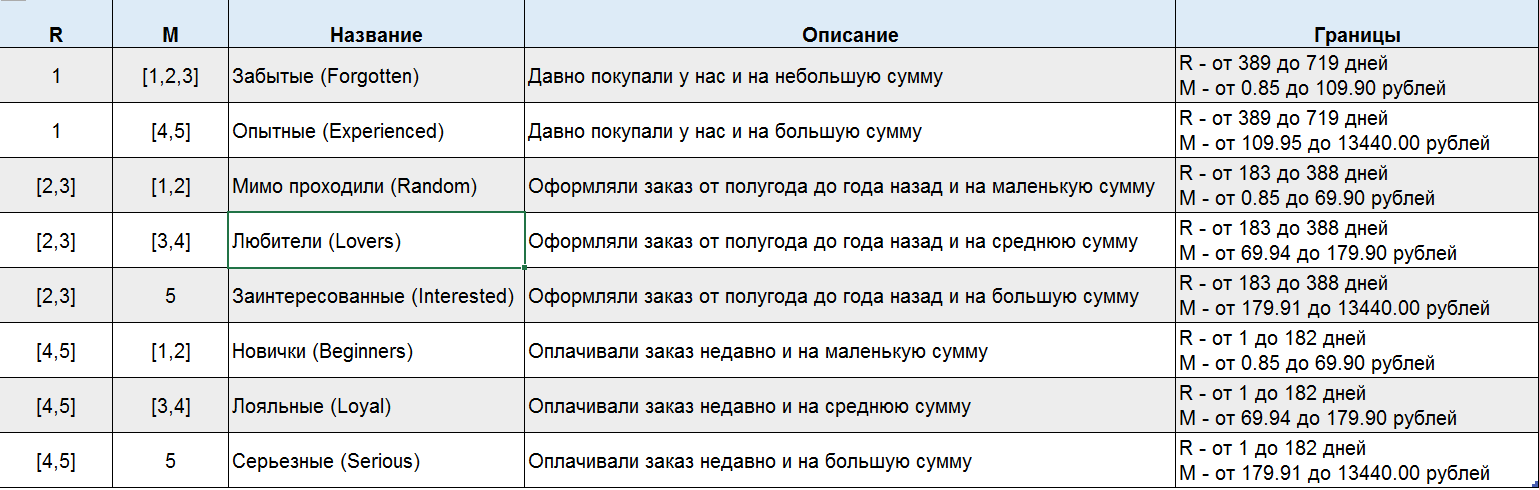

In [85]:
segt_map = {
    r'1[1-2-3]': 'Forgotten',
    r'1[4-5]': 'Experienced',
    r'[2-3][1-2]': 'Random',
    r'[2-3][3-4]': 'Lovers',
    r'[2-3]5': 'Interested',
    r'[4-5][1-2]': 'Beginners',
    r'[4-5][3-4]': 'Loyal',
    r'[4-5]5': 'Serious'
}

rfm['segment'] = rfm['focus_RF_Score'].replace(segt_map, regex=True)
rfm.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM Score,focus_RF_Score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,129.90,4,1,4,414,44,Loyal
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411,41,Beginners
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112,12,Forgotten
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211,21,Random
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,5,215,25,Interested


In [86]:
rfm.segment.value_counts()

Random         15741
Beginners      15384
Loyal          15074
Lovers         14683
Forgotten      11760
Serious         7611
Interested      7492
Experienced     7225
Name: segment, dtype: int64

## Мы провели RFM-сегментацию, а точнее RM-сегментацию, наших клиентов. Интересный подход, который позволяет определить разные группы клиентов. К каждой группе возможны свои определенные маркетинговые подходы.